<a href="https://colab.research.google.com/github/Aashiff2003/DSGP-group-25/blob/Geethmi/Train_Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install pycocotools

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import time
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [ ]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/DSGP/Data/train",
    ann_file="/content/drive/MyDrive/DSGP/Data/train/annotations/annotations.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/DSGP/Data/valid",
    ann_file="/content/drive/MyDrive/DSGP/Data/valid/annotations/annotations.json"
)


# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Initialize the model
num_classes = 2 # Background + Bird
model = get_model(num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 118MB/s]


In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat Mar  8 09:46:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             32W /   70W |   15090MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    start_time = time.time() # Track time for each epoch

    # Train for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state after every epoch
    model_path = f"/content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)

    end_time = time.time()
    print(f"Model saved: {model_path} | Epoch {epoch + 1} completed in {end_time - start_time:.2f} seconds")


Epoch [0] Loss: 0.3680
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_1.pth | Epoch 1 completed in 508.82 seconds
Epoch [1] Loss: 0.2323
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_2.pth | Epoch 2 completed in 202.22 seconds
Epoch [2] Loss: 0.3074
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_3.pth | Epoch 3 completed in 194.26 seconds
Epoch [3] Loss: 0.1184
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_4.pth | Epoch 4 completed in 194.39 seconds
Epoch [4] Loss: 0.2432
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_5.pth | Epoch 5 completed in 194.59 seconds
Epoch [5] Loss: 0.1775
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_6.pth | Epoch 6 completed in 194.68 seconds
Epoch [6] Loss: 0.2030
Model saved: /content/drive/MyDrive/DSGP/Model2/FasterRCNN/faster

Evaluate Model

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
import numpy as np
from torchvision.ops import box_iou
import os
import json

In [ ]:
# Load test annotations
with open("/content/drive/MyDrive/DSGP/Data/test/annotations/annotations.json", "r") as f:
  test_ann = json.load(f)

# Build a dictionary mapping image_id -> filename
image_id_to_filename = {img["id"]: img["file_name"] for img in test_ann["images"]}

# Build a dictionary mapping image_id → ground truth boxes and labels
ground_truth_data = {}
for ann in test_ann["annotations"]:
    image_id = ann["image_id"]
    bbox = ann["bbox"]

    # Convert to [x_min, y_min, x_max, y_max]
    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height
    category_id = ann["category_id"]

    if image_id_to_filename[image_id] not in ground_truth_data:
        ground_truth_data[image_id_to_filename[image_id]] = []

    ground_truth_data[image_id_to_filename[image_id]].append([x_min, y_min, x_max, y_max, category_id])

In [ ]:
# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/DSGP/Model2/FasterRCNN/fasterrcnn_resnet50_epoch_50.pth"), strict=False)
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-23-6815ea6875cf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untruste

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
iou_threshold = 0.1

# define Iou calculation function
def compute_iou(box1, box2):
  x1 = max(box1[0], box1[0])
  y1 = max(box1[1], box1[1])
  x2 = min(box2[2], box2[2])
  y2 = min(box2[3], box2[3])

  inter_area = max(0, x2-x1) * max(0, y2-y1) # Intersection are
  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1]) # Box1 area
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1]) # Box2 area
  union_area = box1_area + box2_area - inter_area # Union area

  return inter_area / union_area if union_area > 0 else 0  # IoU Score

In [ ]:
# path to test images
test_images_dir = "/content/drive/MyDrive/DSGP/Data/test"
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]

results = []

for image_name in test_images:
    image_path = os.path.join(test_images_dir, image_name)
    image = Image.open(image_path).convert("RGB")
    image = image.resize((1024, 1024))
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predicted results
    pred_boxes = predictions[0]['boxes'].cpu().numpy()  # Predicted bounding boxes
    pred_scores = predictions[0]['scores'].cpu().numpy()  # Confidence scores
    pred_labels = predictions[0]['labels'].cpu().numpy()  # Predicted labels

    if image_name in ground_truth_data:  # Ensure key exists
      ground_truth_boxes = np.array([gt[:4] for gt in ground_truth_data[image_name]])
      ground_truth_labels = np.array([gt[4] for gt in ground_truth_data[image_name]])
    else:
      ground_truth_boxes = np.array([])  # No ground truth available
      ground_truth_labels = np.array([])

    # Match predictions to ground truth using IoU
    for pred_box, pred_score, pred_label in zip(pred_boxes, pred_scores, pred_labels):
        best_iou = 0
        best_gt_idx = -1

        for idx, gt_box in enumerate(ground_truth_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx

        is_true_positive = best_iou >= iou_threshold
        results.append([image_name, pred_label, pred_score, "TRUE" if is_true_positive else "FALSE"])

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Image", "Object", "Prediction Score", "Prediction Validity"])
print(df.head())
print(predictions)

                                     Image  Object  Prediction Score  \
0  9c84f834-D01_20210502070930_0056632.png       1          0.236169   
1  9c84f834-D01_20210502070930_0056632.png       1          0.236169   
2  9c84f834-D01_20210502070930_0056632.png       1          0.236169   
3  5a2d14e3-D01_20210201085530_0005823.png       1          0.236169   
4  5a2d14e3-D01_20210201085530_0005823.png       1          0.236169   

  Prediction Validity  
0               FALSE  
1               FALSE  
2               FALSE  
3               FALSE  
4               FALSE  
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


In [ ]:
# Convert TRUE/FALSE to 1/0 for AP calculation
y_true = np.array([1 if res[3] == "TRUE" else 0 for res in results])
y_scores = np.array([res[2] for res in results])

# Compute AP
ap = average_precision_score(y_true, y_scores)
print(f"Mean Average Precision (mAP): {ap:.4f}")

Mean Average Precision (mAP): 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


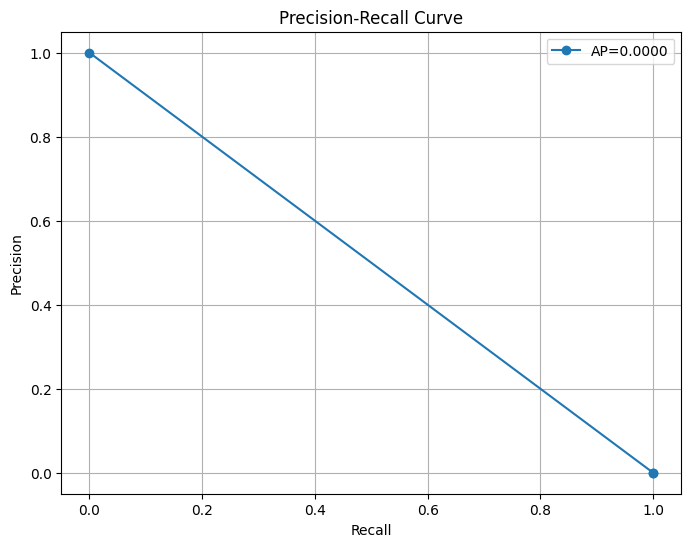

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', label=f"AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()